In [1]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
from sklearn import manifold

import kmapper as km
from kmapper.plotlyviz import *

import gudhi as gd#conda install -c conda-forge gudhi

import tadasets
import persim

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objs as go
from ipywidgets import (HBox, VBox)

In [2]:
######################################
#### Importar datos               ####
######################################
df = pd.read_csv("C://Users/ServW10/Documents/Datasets/betti0AbnormalMessidor.csv",encoding='latin-1')
feature_names = [c for c in df.columns if c not in ["70"]]
#Funcion lambda para clasificacion de datos df["70"] = df["70"].apply(lambda x: 1 if x == "M" else 0)
X = np.array(df["70"])#.fillna(0))
y = np.array(df["70"])
print(X.shape)
X = X.reshape(-1, 1)
print(X.shape)

(653,)
(653, 1)


**Isolation Forest Algorithm.**

Return the anomaly score of each sample using the IsolationForest algorithm
The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly
selecting a split value between the maximum and minimum values of the selected feature.
Since recursive partitioning can be represented by a tree structure, the number of splittings
required to isolate a sample is equivalent to the path length from the root node to the terminating node.
This path length, averaged over a forest of such random trees, is a measure of normality and our decisionfunction.
Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

**For lens1:** Lenses that make biological sense; in other words, lenses that highlight special features in the data, that I know about. In the case of this particualr data, using an anomaly score (in this case calculated using the IsolationForest from sklearn) makes biological sense since cancer cells are anomalous.

**For lens2:** Lenses that disperse the data, as opposed to clustering many points together.

In [3]:
# Create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to get a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Define the simplicial complex
scomplex = mapper.map(lens,
                      X,
                      nr_cubes=15,#15
                      overlap_perc=0.7,#0.7
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

In [4]:
#impresion de la tabla de colores y de distancia
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

color_function = lens [:,0] - lens[:,0].min()
my_colorscale = pl_brewer
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                 color_function,  
                                                                 color_function_name='Distance to x-min', 
                                                                 colorscale=my_colorscale)

# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

In [5]:
#cambio de color para que el grafo se vea mejor
bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# en fondo negro, porque las lineas estan seteadas en gris

In [6]:
#Creacion de la primer vista del grafo
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Red Topologica del Betti0Abnormal dataset',  
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),  
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)

#Aqui se crea la otra vista mas interactiva para el grafo
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor, 
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:
    
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'

In [7]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [8]:
#vista interactiva
dashboard

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

# Construimos el diagrama de Persistencia

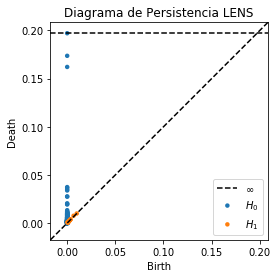

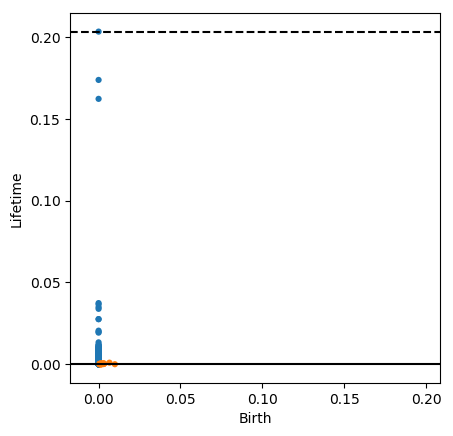

In [9]:

from ripser import ripser
from persim import plot_diagrams

dgms = ripser(lens)['dgms']
plot_diagrams(dgms,title="Diagrama de Persistencia LENS", show=True)
plot_diagrams(dgms, lifetime=True, legend=False)

Deprecated parameter. It has been replaced by max_intervals


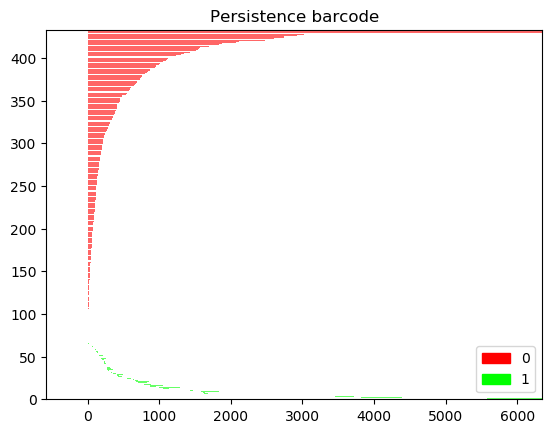

In [10]:
#prueba con Gudhi con datos de AbnormalMessidor
import gudhi
#gudhi.__root_source_dir__ 
off_file = 'C:\\Users\ServW10\Documents\Datasets\\prueba.off' #prueba tiene las columnas 70,71,72 (en ese orden)
point_cloud = gudhi.read_off(off_file=off_file)

rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=6000)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2) #con 3 dimensiones crashea la computadora
diag = simplex_tree.persistence(min_persistence=0.4)#0.4

plot = gudhi.plot_persistence_barcode(diag, legend=True)

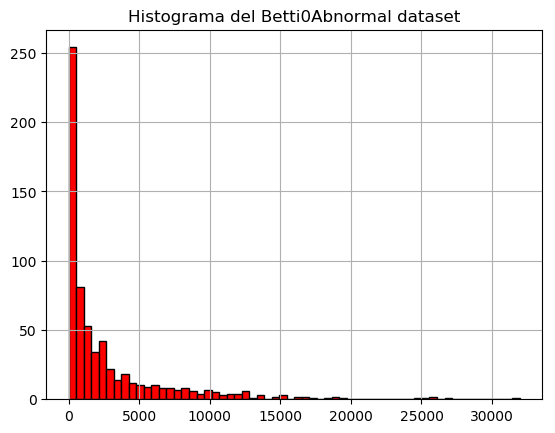

<Figure size 640x480 with 0 Axes>

In [11]:
#Histograma de la columna 70 de AbnormalMessidor
plt.title('Histograma del Betti0Abnormal dataset')
plt.hist(X, bins=60, alpha=1, color = "red", edgecolor = 'black',  linewidth=1)
plt.grid(True)
plt.show()
plt.clf()